In [1]:
import pandas as pd
from sodapy import Socrata
from uszipcode import SearchEngine # note this does an approximation of zipcode based upon a radius
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.options.display.max_columns=20

In [3]:
# Load data from CSV
results_df = pd.read_csv(".\Resources\los_angeles_crime_statistics.csv")
zhi_df = pd.read_csv(".\Resources\CA_zip_home_income.csv")
zhi_df.rename(columns = {"Zip Code":"zipcode"}, inplace = True)

In [4]:
results_df.head()

,Unnamed: 0,area_id,area_name,crm_cd,crm_cd_4,crm_cd_desc,date_occ,date_rptd,dr_no,location,...,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd,lat,lon,zipcode,year
0,0,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-12T00:00:00.000,2010-03-12T00:00:00.000,100700660,7600 BEVERLY BL,...,1050,41.0,B,M,VERBAL THREAT,511.0,34.0761,-118.3555,90036,2010
1,1,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-13T00:00:00.000,2010-03-13T00:00:00.000,100700661,600 S DETROIT ST,...,600,27.0,O,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0649,-118.3451,90036,2010
2,2,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700688,LA CIENEGA BL,...,2350,20.0,H,F,VERBAL THREAT,511.0,34.0730,-118.3765,90048,2010
3,3,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700689,1100 NORTON AV,...,2330,35.0,O,M,UNKNOWN WEAPON/OTHER WEAPON,500.0,34.0516,-118.3219,90005,2010
4,4,7.0,Wilshire,236,NaN,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700719,4400 W WASHINGTON BL,...,2000,43.0,K,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010


In [5]:
# merge crime data with zip/home/income data
home_df = pd.merge(results_df, zhi_df,  how='left', on=["zipcode"])

# drop rows with no home value given
home_df.dropna(subset=["Median Home Value"], inplace=True)

# convert home values to integers
home_df["Median Home Value"] = home_df["Median Home Value"].round(0).astype(int)
home_df.head()

,Unnamed: 0,area_id,area_name,crm_cd,crm_cd_4,crm_cd_desc,date_occ,date_rptd,dr_no,location,...,vict_descent,vict_sex,weapon_desc,weapon_used_cd,lat,lon,zipcode,year,Median Home Value,Median Household Income
0,0,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-12T00:00:00.000,2010-03-12T00:00:00.000,100700660,7600 BEVERLY BL,...,B,M,VERBAL THREAT,511.0,34.0761,-118.3555,90036,2010,945000,71589.0
1,1,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-13T00:00:00.000,2010-03-13T00:00:00.000,100700661,600 S DETROIT ST,...,O,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0649,-118.3451,90036,2010,945000,71589.0
2,2,7.0,Wilshire,930,NaN,CRIMINAL THREATS - NO WEAPON DISPLAYED,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700688,LA CIENEGA BL,...,H,F,VERBAL THREAT,511.0,34.0730,-118.3765,90048,2010,941100,72701.0
3,3,7.0,Wilshire,626,NaN,INTIMATE PARTNER - SIMPLE ASSAULT,2010-03-23T00:00:00.000,2010-03-24T00:00:00.000,100700689,1100 NORTON AV,...,O,M,UNKNOWN WEAPON/OTHER WEAPON,500.0,34.0516,-118.3219,90005,2010,633600,31893.0
4,4,7.0,Wilshire,236,NaN,INTIMATE PARTNER - AGGRAVATED ASSAULT,2010-04-05T00:00:00.000,2010-04-05T00:00:00.000,100700719,4400 W WASHINGTON BL,...,K,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400.0,34.0399,-118.3353,90019,2010,617300,42043.0


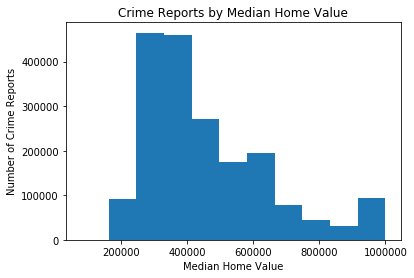

In [10]:
# plot number of crime reports over housing values
mhv = home_df["Median Home Value"]
plt.hist(mhv, bins = 11)
plt.xlabel("Median Home Value")
plt.ylabel("Number of Crime Reports")
plt.title('Crime Reports by Median Home Value')
plt.show()

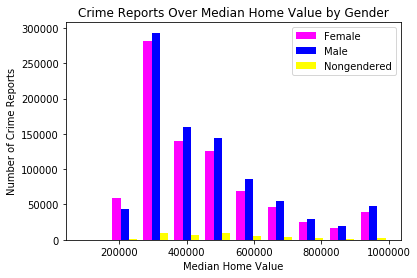

In [28]:
# Create subsets of dataframe by gender (female, male, unspecified/nongendered)
f_df = home_df.loc[home_df["vict_sex"] == "F"]
m_df = home_df.loc[home_df["vict_sex"] == "M"]
nongendered = ["X", "H", "N", "-"]
x_df = home_df.loc[home_df["vict_sex"].isin(nongendered)]

# Plot crime reports over home values by gender
f_mhv = f_df["Median Home Value"]
m_mhv = m_df["Median Home Value"]
x_mhv = x_df["Median Home Value"]

legend = ["Female", "Male", "Nongendered"]
plt.hist([f_mhv, m_mhv, x_mhv], color=["magenta", "blue", "yellow"])
plt.xlabel("Median Home Value")
plt.ylabel("Number of Crime Reports")
plt.title('Crime Reports Over Median Home Value by Gender')
plt.legend(legend)
plt.show()

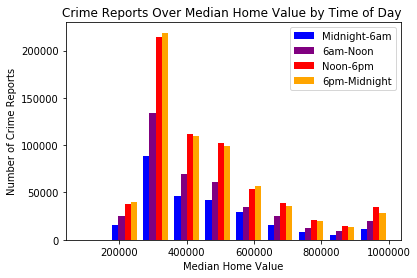

In [29]:
# Create subsets of dataframe by time of day (early morning, morning, afternoon, night)
early_df = home_df.loc[home_df["time_occ"] <= 599]

morn_df_temp = home_df.loc[home_df["time_occ"] <= 1199]
morn_df = morn_df_temp.loc[home_df["time_occ"] >= 600]

after_df_temp = home_df.loc[home_df["time_occ"] <= 1799]
after_df = after_df_temp.loc[home_df["time_occ"] >= 1200]

late_df = home_df.loc[home_df["time_occ"] >= 1800]

# Plot crime reports over home values by gender
early_mhv = early_df["Median Home Value"]
morn_mhv = morn_df["Median Home Value"]
after_mhv = after_df["Median Home Value"]
late_mhv = late_df["Median Home Value"]

legend = ["Midnight-6am", "6am-Noon", "Noon-6pm", "6pm-Midnight"]
plt.hist([early_mhv, morn_mhv, after_mhv, late_mhv], color=["blue", "purple", "red", "orange"])
plt.xlabel("Median Home Value")
plt.ylabel("Number of Crime Reports")
plt.title('Crime Reports Over Median Home Value by Time of Day ')
plt.legend(legend)
plt.show()

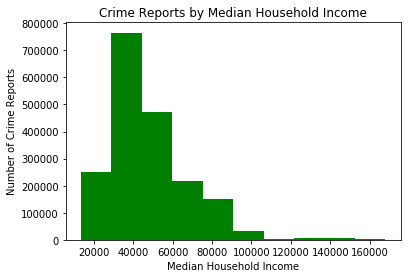

In [30]:
# plot number of crime reports over housing values
mhi = home_df["Median Household Income"]
plt.hist(mhi, bins = 10, color = "green")
plt.xlabel("Median Household Income")
plt.ylabel("Number of Crime Reports")
plt.title("Crime Reports by Median Household Income")
plt.show()

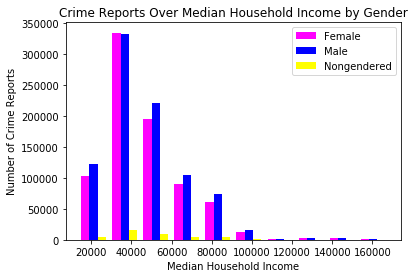

In [32]:
# Plot crime reports over income by gender
f_mhi = f_df["Median Household Income"]
m_mhi = m_df["Median Household Income"]
x_mhi = x_df["Median Household Income"]

legend = ["Female", "Male", "Nongendered"]
plt.hist([f_mhi, m_mhi, x_mhi], color=["magenta", "blue", "yellow"])
plt.xlabel("Median Household Income")
plt.ylabel("Number of Crime Reports")
plt.title('Crime Reports Over Median Household Income by Gender')
plt.legend(legend)
plt.show()

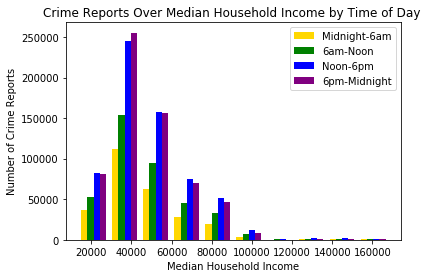

In [34]:
# Create subsets of income dataframe by time of day (early morning, morning, afternoon, night)
early_mhi = early_df["Median Household Income"]
morn_mhi = morn_df["Median Household Income"]
after_mhi = after_df["Median Household Income"]
late_mhi = late_df["Median Household Income"]

# Plot 
legend = ["Midnight-6am", "6am-Noon", "Noon-6pm", "6pm-Midnight"]
plt.hist([early_mhi, morn_mhi, after_mhi, late_mhi], color=["gold", "green", "blue", "purple"])
plt.xlabel("Median Household Income")
plt.ylabel("Number of Crime Reports")
plt.title('Crime Reports Over Median Household Income by Time of Day ')
plt.legend(legend)
plt.show()